In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume import PlaneWaveExp, GuidedModeExp, Circle, ShapesLayer, Lattice, PhotCryst
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

In [2]:
# PhC parameters
a = 420
ra = 0.5*256/a       # hole radius
eps_b = 3.453**2      # slab permittivity (n ~= 3.453 at low temp, n = 3.48 at room temp)
#eps_b = 11.7
eps_c = 1            # hole permittivity
d = 220/420          # slab thickness

# plane-wave expansion parameters
gmax = 2     # truncation of the plane-wave basis
Ny = 14      # Number of rows in the y-direction
Ny_opt = 3   # Number of rows in which the pillars will be modified
Nx = 1       # Supercell size in the x-direction

W = 0.945     # Waveguide Width (0.98 in Zhuang)

# Initialize a rectangular lattice
lattice = Lattice([Nx, 0], [0, (Ny+W-1)*np.sqrt(3)/2])

def wg_sc(dx, dy, dr):
    """Define the photonic crystal waveguide given shift parameters
    dx, dy, and dr, for the 2*Nx*Ny_opt number of pillars that get shifted
    """
    phc = PhotCryst(lattice, eps_l = 1, eps_u = 1)
    
    # Initialize a layer and the positions of the pillars for the regular waveguide
    phc.add_layer(d=d, eps_b=eps_b)
    
    xc = []; yc = []
    for ih in range(Ny):
        if ih != Ny//2:
            for ix in range(-Nx//2+1, Nx//2+1):
                xc.append((ih%2)*0.5 + ix)
                if ih <= Ny//2:
                    yc.append((-Ny//2 + ih + (1-W)/2)*np.sqrt(3)/2)
                else:
                    yc.append((-Ny//2 + ih - (1-W)/2)*np.sqrt(3)/2)

    # Add all the pillars, taking care of the shifts
    for ih in range(1, Ny//2+1):
        nx1 = (Ny//2+ih-1)
        nx2 = (Ny//2-ih)
        if ih <= Ny_opt:
            # The ih row includes "optimization" pillars
            for ix in range(Nx):
                circ = Circle(x_cent=xc[nx1*Nx + ix] + dx[(ih-1)*Nx + ix],
                              y_cent=yc[nx1*Nx + ix] + dy[(ih-1)*Nx  + ix],
                              r = ra + dr[(ih-1)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
                circ = Circle(x_cent=xc[nx2*Nx + ix] + dx[(ih-1+Ny_opt)*Nx  + ix],
                              y_cent=yc[nx2*Nx + ix] + dy[(ih-1+Ny_opt)*Nx  + ix],
                              r = ra + dr[(ih-1+Ny_opt)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
        else:
            # The ih row includes just regular pillars
            for ix in range(Nx):
                circ = Circle(x_cent = xc[nx2*Nx + ix], y_cent=yc[nx2*Nx + ix], r=ra, eps=eps_c)
                phc.add_shape(circ)
                if ih < Ny//2:
                    circ = Circle(x_cent = xc[nx1*Nx + ix], y_cent=yc[nx1*Nx + ix], r=ra, eps=eps_c)
                    phc.add_shape(circ)

    # Construct and return a plane-wave expansion object
    return phc

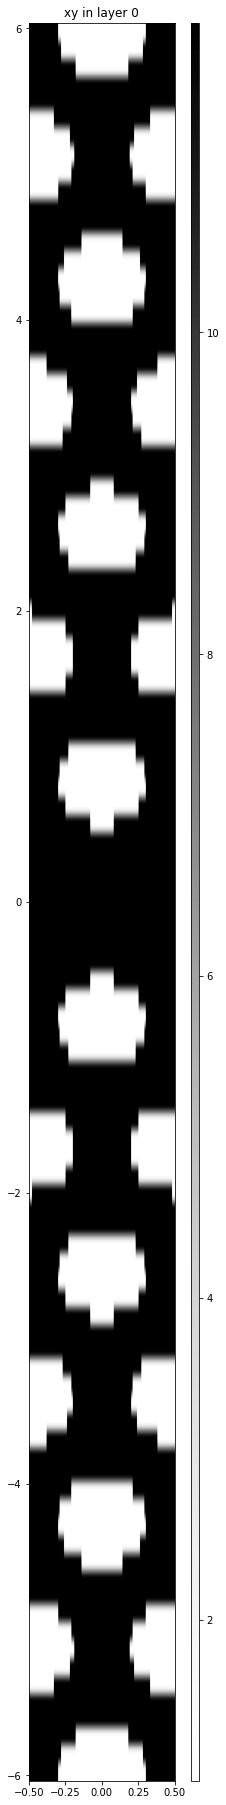

In [3]:
# Initialize zero shifts
dx0 = np.zeros((Nx*2*Ny_opt, ))
dy0 = np.zeros((Nx*2*Ny_opt, ))
dr0 = np.zeros((Nx*2*Ny_opt, ))

# Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
phc0 = wg_sc(dx0, dy0, dr0)
legume.viz.structure(phc0, xz=False, xy=True, figsize=3)

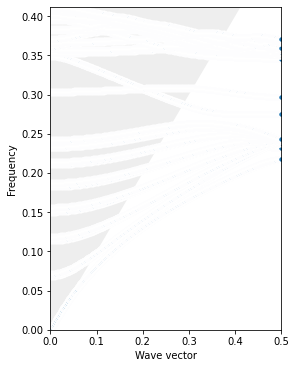

In [4]:
nk = 500

# Define a BZ path in kx
path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nk])
#pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

neig = 30

# Initialize GME
gme = legume.GuidedModeExp(phc0, gmax=gmax)

# Set some of the running options
options = {'gmode_inds': [0], 
           'numeig': neig,
           'verbose': False
            }

# Run the simulation
gme.run(kpoints=path['kpoints'], **options)

# Visualize the bands
ax = legume.viz.bands(gme, Q=False)

In [5]:
f_ind = np.linspace(0, 1, neig)
k = np.linspace(0, 0.5, nk+1)
fv, kv = np.meshgrid(f_ind, k)
# print(kv)
n_eff = kv/gme.freqs
wvln = a/gme.freqs

Text(0, 0.5, 'Effective Index $n_{eff}$')

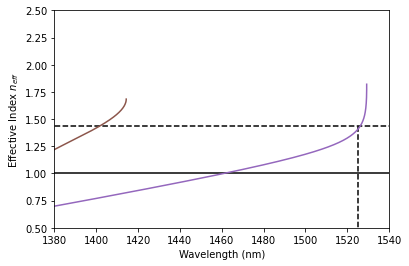

In [6]:
ind = 14 # Index of mode in question

plt.plot([1380,1540],[1,1],'k-')  # Light Line
plt.plot([0,10000],[1.44,1.44], 'k--') # Silica Index
plt.plot([1525,1525],[0,1.44], 'k--') # Wavelength in Question
#plt.plot(wvln[:,ind], n_eff[:,ind])  
plt.plot(wvln, n_eff)
plt.xlim([1380,1540])
#plt.xlim([1650,1750])
plt.ylim([0.5,2.5])
plt.xlabel("Wavelength (nm)")
plt.ylabel(r"Effective Index $n_{eff}$")

In [7]:
n_target = 1.44
n_diff = n_target - n_eff[:,ind]
print(n_diff)

[ 1.44000000e+00  1.43670605e+00  1.43341211e+00  1.43011818e+00
  1.42682428e+00  1.42353042e+00  1.42023659e+00  1.41694281e+00
  1.41364909e+00  1.41035543e+00  1.40706184e+00  1.40376834e+00
  1.40047493e+00  1.39718161e+00  1.39388839e+00  1.39059529e+00
  1.38730232e+00  1.38400947e+00  1.38071675e+00  1.37742419e+00
  1.37413177e+00  1.37083952e+00  1.36754743e+00  1.36425552e+00
  1.36096380e+00  1.35767227e+00  1.35438094e+00  1.35108982e+00
  1.34779891e+00  1.34450823e+00  1.34121778e+00  1.33792757e+00
  1.33463760e+00  1.33134789e+00  1.32805845e+00  1.32476927e+00
  1.32148037e+00  1.31819176e+00  1.31490344e+00  1.31161542e+00
  1.30832771e+00  1.30504031e+00  1.30175324e+00  1.29846649e+00
  1.29518009e+00  1.29189403e+00  1.28860832e+00  1.28532297e+00
  1.28203799e+00  1.27875338e+00  1.27546916e+00  1.27218532e+00
  1.26890188e+00  1.26561885e+00  1.26233622e+00  1.25905401e+00
  1.25577222e+00  1.25249086e+00  1.24920995e+00  1.24592947e+00
  1.24264945e+00  1.23936

In [8]:
zero_crossings = np.where(np.diff(np.sign(n_diff)))
#print(np.sign(n_diff))
#print(np.diff(np.sign(n_diff)))
#print(zero_crossings)
print(float(wvln[zero_crossings, ind]))

1526.2689539160426


In [9]:
wvln_target = 1518.37
wvln_diff = wvln_target - wvln[:,ind]
print(wvln_diff)
w_zero_crossings = np.where(np.diff(np.sign(wvln_diff)))
#print(np.sign(n_diff))
#print(np.diff(np.sign(n_diff)))
#print(zero_crossings)
print(wvln[w_zero_crossings, ind])

[ 1.34910762e+02  1.34911329e+02  1.34913031e+02  1.34915867e+02
  1.34919838e+02  1.34924942e+02  1.34931180e+02  1.34938551e+02
  1.34947055e+02  1.34956691e+02  1.34967459e+02  1.34979358e+02
  1.34992386e+02  1.35006545e+02  1.35021831e+02  1.35038245e+02
  1.35055786e+02  1.35074452e+02  1.35094242e+02  1.35115155e+02
  1.35137190e+02  1.35160345e+02  1.35184619e+02  1.35210011e+02
  1.35236518e+02  1.35264140e+02  1.35292875e+02  1.35322720e+02
  1.35353674e+02  1.35385736e+02  1.35418903e+02  1.35453174e+02
  1.35488546e+02  1.35525017e+02  1.35562585e+02  1.35601249e+02
  1.35641005e+02  1.35681852e+02  1.35723786e+02  1.35766807e+02
  1.35810911e+02  1.35856095e+02  1.35902357e+02  1.35949695e+02
  1.35998106e+02  1.36047587e+02  1.36098135e+02  1.36149747e+02
  1.36202421e+02  1.36256154e+02  1.36310941e+02  1.36366782e+02
  1.36423671e+02  1.36481606e+02  1.36540584e+02  1.36600602e+02
  1.36661655e+02  1.36723741e+02  1.36786856e+02  1.36850997e+02
  1.36916159e+02  1.36982

In [18]:
import scipy as sc
tck = sc.interpolate.splrep(wvln[:,ind],n_eff[:,ind], s=0)
n_eff_wvln = sc.interpolate.splev([wvln_target], tck, der=0)
print(n_eff_wvln)

ValueError: Error on input data

In [19]:
print(len(wvln[:,ind]))
print(len(n_eff[:,ind]))
print(wvln[:,ind])
print(n_eff[:,ind])

501
501
[1383.45923774 1383.45867057 1383.45696881 1383.45413266 1383.45016235
 1383.44505804 1383.4388201  1383.4314489  1383.42294498 1383.41330885
 1383.40254107 1383.39064241 1383.37761359 1383.36345542 1383.3481688
 1383.33175468 1383.3142141  1383.29554814 1383.27575797 1383.25484481
 1383.23280996 1383.2096547  1383.18538058 1383.15998901 1383.13348154
 1383.10585981 1383.0771254  1383.04728009 1383.01632565 1382.98426393
 1382.95109683 1382.91682632 1382.8814544  1382.84498316 1382.80741472
 1382.76875128 1382.72899508 1382.68814842 1382.64621356 1382.60319311
 1382.55908943 1382.51390505 1382.46764257 1382.4203046  1382.37189383
 1382.32241299 1382.27186495 1382.22025255 1382.16757864 1382.11384638
 1382.05905859 1382.00321844 1381.9463291  1381.88839375 1381.82941568
 1381.76939824 1381.70834478 1381.64625879 1381.58314375 1381.51900327
 1381.45384098 1381.38766059 1381.32046576 1381.25226055 1381.18304875
 1381.11283434 1381.04162139 1380.96941395 1380.89621624 1380.8220325


In [21]:
wvln_ind = wvln[:,ind]
n_eff_ind = n_eff[:,ind]

sort = np.argsort(wvln_ind)

wvln_sort = wvln_ind[sort]
n_eff_sort = n_eff_ind[sort]

tck = sc.interpolate.splrep(wvln_sort,n_eff_sort, s=0)
n_eff_wvln = sc.interpolate.splev(wvln_target, tck, der=0)
print(n_eff_wvln)

1.3079087550459956
